### Import dependencies

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD, Adam
from torch.utils.data import Dataset

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import time
import datetime
import numpy as np

from ignite.metrics.recall import Recall
from ignite.engine import *

def eval_step(engine, batch):
    return batch

default_evaluator = Engine(eval_step)
test_evaluator = Engine(eval_step)  # ?

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Prepare Dataloader

In [2]:
class SER_Dataset(Dataset):
    def __init__(self, data_path):
        """
        Аргументы:
            data_path -- путь к папке извлеченными признаками
        """
        
        self._ids = list([])    # speaker IDs

        X = pd.read_csv("../../data/2023-11-08/feature_mfcc_34_delta_delta_nfft_4096.csv", index_col=0)
        y = pd.read_csv('../../data/2023-11-08/y_labels_feature_34_mfcc_delta_delta_nfft_4096.csv', index_col=0)
        ID= pd.read_csv('../../data/2023-11-08/IDs_feature_mfcc_34_delta_delta_nfft_4096.csv', index_col=0)

        # Convert features and labels to numpy arrays
        X = X.values
        y.replace({'neutral':0, 'calm':1, 'happy':2, 'sad':3, 'angry':4, 'fear':5, 'disgust':6, 'surprised':7}, inplace=True)
        y = torch.tensor(y.values)
        self.y = torch.nn.functional.one_hot(y, num_classes=8)
        self.y = self.y.squeeze(dim=1)
        self.y = self.y.float()
        self.X = torch.from_numpy(X).float()

        self.folds = list(([2, 5, 14, 15, 16], # 0
                           [3, 6, 7, 13, 18], # 1
                           [10, 11, 12, 19, 20], # 2
                           [8, 17, 21, 23, 24], # 3
                           [1, 4, 9, 22]))     # 4

        self.folds_val = list(([3, 6],
                              [10, 11],
                              [8, 17],
                              [1, 14],
                              [2, 5]))

        self.X_ids = list(np.array(ID.values).squeeze())        
       
        # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # self.X = self.X.to(device)
        # self.y = self.y.to(device)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, index):
        return self.X[index,:], self.y[index,:]

    def get_kth_fold_inds(self, fold_num):
        ids_train = list([])
        ids_val  = list([])
        ids_test = list([])
        for i in range(len(self.X_ids)):
            # print(self.X_ids[i])
            # print(self.folds[fold_num])
            if self.X_ids[i] in self.folds[fold_num]:
                ids_test.append(i)
            elif self.X_ids[i] in self.folds_val[fold_num]:
                ids_val.append(i)
            else:
                ids_train.append(i)
        return (ids_train,ids_val, ids_test)

In [3]:
## test dataloader
SER_data_set = SER_Dataset('')
# print(len(SER_data_set))
# X,y = SER_data_set[2]
# print(X)
# print(y)
# ids_train,ids_val, ids_test = SER_data_set.get_kth_fold_inds(4)

# Linear NN

In [5]:
class SER_one_layer_NN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(SER_one_layer_NN, self).__init__()
        self.fc1 = nn.Linear(input_size, num_classes)        
        self.num_classes = num_classes

        torch.manual_seed(702)
        nn.init.xavier_uniform_(self.fc1.weight)        


    def forward(self, x):
        # Multiply input by weights and add biases
        linear_output = self.fc1(x)
        SER_out = torch.nn.functional.softmax(linear_output, dim=0)
        return SER_out

## Model test

In [11]:
X,y = SER_data_set[2]
model = SER_one_layer_NN(len(X), y.shape[0])
y_out = model(X)

# Development of train/val/test loop

Epoch 1: 100%|██████████| 204/204 [00:00<00:00, 911.01it/s]


2024-03-17 21:39:49.619595 Epoch 1, Train loss 2.016, Val loss 1.937, UAR_val = 0.359


Epoch 2: 100%|██████████| 204/204 [00:00<00:00, 1015.25it/s]


2024-03-17 21:39:49.834527 Epoch 2, Train loss 1.946, Val loss 1.887, UAR_val = 0.391


Epoch 3: 100%|██████████| 204/204 [00:00<00:00, 868.36it/s]


2024-03-17 21:39:50.083447 Epoch 3, Train loss 1.903, Val loss 1.862, UAR_val = 0.469


Epoch 4: 100%|██████████| 204/204 [00:00<00:00, 906.95it/s]


2024-03-17 21:39:50.322370 Epoch 4, Train loss 1.850, Val loss 1.854, UAR_val = 0.461


Epoch 5: 100%|██████████| 204/204 [00:00<00:00, 832.01it/s]


2024-03-17 21:39:50.583555 Epoch 5, Train loss 1.850, Val loss 1.837, UAR_val = 0.445


Epoch 6: 100%|██████████| 204/204 [00:00<00:00, 790.95it/s]


2024-03-17 21:39:50.856469 Epoch 6, Train loss 1.830, Val loss 1.813, UAR_val = 0.531


Epoch 7: 100%|██████████| 204/204 [00:00<00:00, 915.10it/s]


2024-03-17 21:39:51.100392 Epoch 7, Train loss 1.809, Val loss 1.803, UAR_val = 0.531


Epoch 8: 100%|██████████| 204/204 [00:00<00:00, 967.14it/s]


2024-03-17 21:39:51.325319 Epoch 8, Train loss 1.808, Val loss 1.794, UAR_val = 0.539


Epoch 9: 100%|██████████| 204/204 [00:00<00:00, 887.24it/s]


2024-03-17 21:39:51.570240 Epoch 9, Train loss 1.798, Val loss 1.801, UAR_val = 0.531


Epoch 10: 100%|██████████| 204/204 [00:00<00:00, 962.57it/s]


2024-03-17 21:39:51.797167 Epoch 10, Train loss 1.781, Val loss 1.801, UAR_val = 0.500


Epoch 11: 100%|██████████| 204/204 [00:00<00:00, 985.82it/s]


2024-03-17 21:39:52.017097 Epoch 11, Train loss 1.783, Val loss 1.799, UAR_val = 0.562


Epoch 12: 100%|██████████| 204/204 [00:00<00:00, 767.16it/s]


2024-03-17 21:39:52.297008 Epoch 12, Train loss 1.757, Val loss 1.789, UAR_val = 0.578


Epoch 13: 100%|██████████| 204/204 [00:00<00:00, 958.06it/s]


2024-03-17 21:39:52.526936 Epoch 13, Train loss 1.767, Val loss 1.795, UAR_val = 0.578


Epoch 14: 100%|██████████| 204/204 [00:00<00:00, 900.71it/s]


2024-03-17 21:39:52.768418 Epoch 14, Train loss 1.749, Val loss 1.793, UAR_val = 0.555


Epoch 15: 100%|██████████| 204/204 [00:00<00:00, 990.30it/s]


2024-03-17 21:39:52.990413 Epoch 15, Train loss 1.737, Val loss 1.786, UAR_val = 0.578


Epoch 16: 100%|██████████| 204/204 [00:00<00:00, 898.59it/s]


2024-03-17 21:39:53.236428 Epoch 16, Train loss 1.752, Val loss 1.787, UAR_val = 0.586


Epoch 17: 100%|██████████| 204/204 [00:00<00:00, 957.76it/s]


2024-03-17 21:39:53.465420 Epoch 17, Train loss 1.752, Val loss 1.788, UAR_val = 0.562


Epoch 18: 100%|██████████| 204/204 [00:00<00:00, 962.25it/s]


2024-03-17 21:39:53.693419 Epoch 18, Train loss 1.740, Val loss 1.785, UAR_val = 0.555


Epoch 19: 100%|██████████| 204/204 [00:00<00:00, 980.75it/s]


2024-03-17 21:39:53.917418 Epoch 19, Train loss 1.753, Val loss 1.780, UAR_val = 0.562


Epoch 20: 100%|██████████| 204/204 [00:00<00:00, 980.75it/s]

2024-03-17 21:39:54.139417 Epoch 20, Train loss 1.739, Val loss 1.772, UAR_val = 0.570
 UAR_test = 0.509


Text(0, 0.5, 'Ошибка обучения')

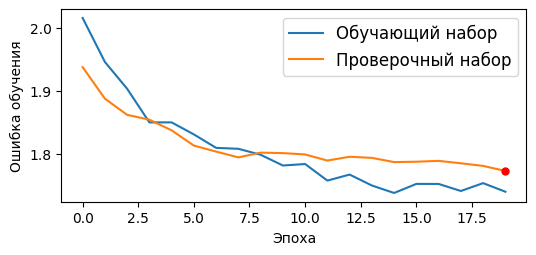

In [7]:
# Этот код использовался для написания и отладки всех последующих процедур

model = SER_one_layer_NN(306,8)
n_epochs = 20

optimizer = Adam(model.parameters(),lr=5e-4, weight_decay=1e-2) # weight_decay is L2 regularization
loss_fn = nn.CrossEntropyLoss()

SER_data_set = SER_Dataset('')

inds_train,inds_val,inds_test = SER_data_set.get_kth_fold_inds(0)
train_set = torch.utils.data.dataset.Subset(SER_data_set, inds_train)
val_set = torch.utils.data.dataset.Subset(SER_data_set, inds_val)
test_set = torch.utils.data.dataset.Subset(SER_data_set, inds_test)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=5,shuffle=True)  # num_workers=2
val_loader = torch.utils.data.DataLoader(val_set, batch_size=5, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=5, shuffle=False) 

metric = Recall()
macro_metric = Recall(average=True)

metric.attach(default_evaluator, "recall")
macro_metric.attach(default_evaluator, "macro recall")

macro_metric.attach(test_evaluator, "macro recall")

MODEL_PATH = "model_backup/model_nn.pt"
loss_train_history = np.ndarray((n_epochs))
loss_val_history = np.ndarray((n_epochs))
lrs = []
best_epoch = -1
loss_val_min = 100
for epoch in range(1,n_epochs+1):
    model.train()
    loss_train = 0.0
    for X, labels in tqdm(train_loader, desc=f"Epoch {epoch}", leave=True): #train_loader:        
        outputs = model(X)
        outputs = outputs.squeeze(dim=1) # for batch train_loader
        loss = loss_fn(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_train += loss.item()
    loss_train = loss_train / len(train_loader)

    # prediction on val set
    loss_val = 0.0
    model.eval()
    val_pred = []
    val_true = []
    with torch.no_grad():
        for X, labels in val_loader:
            pred = model(X)
            pred = pred.squeeze(dim=1) # for batch train_loader

            loss = loss_fn(pred, labels)
            loss_val += loss.item()

            # _,pred = torch.max(pred, dim=1)
            _,labels = torch.max(labels, dim=1)

            val_pred.append(pred)
            val_true.append(labels)                        

        val_pred = torch.cat(val_pred)
        val_true = torch.cat(val_true)

        default_evaluator.terminate()
        state = default_evaluator.run([[val_pred, val_true]])
        # print(f"Recall: {state.metrics['recall']}")
        # print(f"Macro Recall: {state.metrics['macro recall']}")

        loss_val = loss_val / len(val_loader)

        loss_train_history[epoch-1] = loss_train
        loss_val_history[epoch-1] = loss_val

        if loss_val < loss_val_min:
            torch.save(model.state_dict(), MODEL_PATH)
            loss_val_min = loss_val
            best_epoch = epoch-1
        UAR = state.metrics['macro recall']
        print(f'{datetime.datetime.now()} Epoch {epoch}, Train loss {loss_train:.3f}, Val loss {loss_val:.3f}, UAR_val = {UAR:.3f}')

model.load_state_dict(torch.load(MODEL_PATH))

# prediction on test set
test_pred = []
test_true = []
model.eval()
with torch.no_grad():
    i = 0
    for X, labels in test_loader:    
        pred = model(X)
        # pred = torch.squeeze(pred,1)
        # pred = torch.squeeze(pred)        
        # label = torch.squeeze(label,0)
        _,labels = torch.max(labels, dim=1)

        test_pred.append(pred)
        test_true.append(labels)                        

    test_pred = torch.cat(test_pred)
    test_true = torch.cat(test_true)

    test_evaluator.terminate()
    state = test_evaluator.run([[test_pred, test_true]])

UAR_test = state.metrics['macro recall']
print(f' UAR_test = {UAR_test:.3f}')        

fig, ax = plt.subplots(figsize=(6,2.5))
plt.rcParams.update({'font.size': 12})
# plt.subplot(1,2,1)
plt.plot(range(n_epochs), loss_train_history, label='Обучающий набор')
plt.plot(range(n_epochs), loss_val_history, label='Проверочный набор')
plt.plot(best_epoch,loss_val_min,color='red', marker='o', linewidth=1, markersize=5)
plt.legend()
plt.xlabel('Эпоха')
plt.ylabel('Ошибка обучения')

# Train loop

In [35]:
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader, val_loader):
    metric = Recall()
    macro_metric = Recall(average=True)        

    macro_metric.attach(test_evaluator, "macro recall")

    MODEL_PATH = "model_backup/model_nn.pt"
    loss_train_history = np.ndarray((n_epochs))
    loss_val_history = np.ndarray((n_epochs))
    best_epoch = -1
    loss_val_min = 100
    for epoch in range(1,n_epochs+1):
        model.train()
        loss_train = 0.0
        for X, labels in tqdm(train_loader, desc=f"Epoch {epoch}", leave=True): #train_loader:        
            outputs = model(X)
            outputs = outputs.squeeze(dim=1) # for batch train_loader
            loss = loss_fn(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()
        loss_train = loss_train / len(train_loader)

        # prediction on val set
        loss_val = 0.0
        model.eval()
        val_pred = []
        val_true = []
        with torch.no_grad():
            for X, labels in val_loader:
                pred = model(X)
                pred = pred.squeeze(dim=1) # for batch train_loader

                loss = loss_fn(pred, labels)
                loss_val += loss.item()

                # _,pred = torch.max(pred, dim=1)
                _,labels = torch.max(labels, dim=1)

                val_pred.append(pred)
                val_true.append(labels)                        

            val_pred = torch.cat(val_pred)
            val_true = torch.cat(val_true)

            default_evaluator.terminate()
            state = default_evaluator.run([[val_pred, val_true]])

            loss_val = loss_val / len(val_loader)

            loss_train_history[epoch-1] = loss_train
            loss_val_history[epoch-1] = loss_val

            if loss_val < loss_val_min:
                torch.save(model.state_dict(), MODEL_PATH)
                loss_val_min = loss_val
                best_epoch = epoch-1
            UAR = state.metrics['macro recall']
            if epoch==1 or epoch%5==0:
                print(f'{datetime.datetime.now()} Epoch {epoch}, Train loss {loss_train:.3f}, Val loss {loss_val:.3f}, UAR_val = {UAR:.3f}')

        model.load_state_dict(torch.load(MODEL_PATH))

    # fig, ax = plt.subplots(figsize=(6,2.5))
    # plt.rcParams.update({'font.size': 12})
    # plt.plot(range(n_epochs), loss_train_history, label='Обучающий набор')
    # plt.plot(range(n_epochs), loss_val_history, label='Проверочный набор')
    # plt.plot(best_epoch,loss_val_min,color='red', marker='o', linewidth=1, markersize=5)
    # plt.legend()
    # plt.xlabel('Эпоха')
    # plt.ylabel('Ошибка обучения')
    # plt.show()
        
    # Saving results
    # image_name = f'figures/loss_NN.jpg'
    # fig.savefig(image_name, format='jpg', dpi=110, bbox_inches='tight', pad_inches = 0.2)
    return (loss_train_history,loss_val_history,loss_val_min,best_epoch)

Epoch 1: 100%|██████████| 204/204 [00:00<00:00, 1005.25it/s]


2024-03-17 22:10:16.029081 Epoch 1, Train loss 2.016, Val loss 1.937, UAR_val = 0.359


Epoch 2: 100%|██████████| 204/204 [00:00<00:00, 965.32it/s]


2024-03-17 22:10:16.262909 Epoch 2, Train loss 1.946, Val loss 1.887, UAR_val = 0.391


Epoch 3: 100%|██████████| 204/204 [00:00<00:00, 962.80it/s]


2024-03-17 22:10:16.498208 Epoch 3, Train loss 1.903, Val loss 1.862, UAR_val = 0.469


Epoch 4: 100%|██████████| 204/204 [00:00<00:00, 1000.32it/s]


2024-03-17 22:10:16.724136 Epoch 4, Train loss 1.850, Val loss 1.854, UAR_val = 0.461


Epoch 5: 100%|██████████| 204/204 [00:00<00:00, 1010.23it/s]


2024-03-17 22:10:16.947065 Epoch 5, Train loss 1.850, Val loss 1.837, UAR_val = 0.445


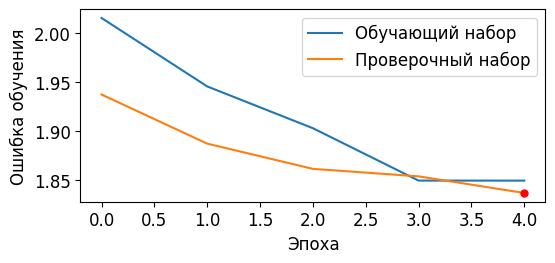

In [10]:
model = SER_one_layer_NN(306,8)
n_epochs = 5

optimizer = Adam(model.parameters(),lr=5e-4, weight_decay=1e-2) # weight_decay is L2 regularization
loss_fn = nn.CrossEntropyLoss()

SER_data_set = SER_Dataset('')

loss_train_history, loss_val_history, loss_val_min, best_epoch = training_loop(n_epochs, optimizer, model, loss_fn, train_loader, val_loader)

# k-fold CV

In [39]:
def k_fold_CV(dataset=None, model = None, loss_fn = None, optimizer = None, n_epochs = 20, k_fold=5):
    MODEL_PATH = "model_backup/model_nn.pt"
    INIT_MODEL_PATH = "model_backup/model_nn_init.pt"

    torch.save(model.state_dict(), INIT_MODEL_PATH)

    macro_metric = Recall(average=True)
    macro_metric.attach(test_evaluator, "macro recall")

    test_pred = []
    test_true = []
    
    loss_train_history_list = list()
    loss_val_history_list = list()
    loss_val_best_hist = list()
    best_epoch_hist = list()
    
    for i in range(k_fold):

        inds_train,inds_val,inds_test = dataset.get_kth_fold_inds(i)

        train_set = torch.utils.data.dataset.Subset(dataset,inds_train)
        val_set = torch.utils.data.dataset.Subset(dataset,inds_val)
        test_set = torch.utils.data.dataset.Subset(dataset,inds_test)

        train_loader = torch.utils.data.DataLoader(train_set, batch_size=5,shuffle=True)  # num_workers=2
        val_loader = torch.utils.data.DataLoader(val_set, batch_size=5, shuffle=False)
        test_loader = torch.utils.data.DataLoader(test_set, batch_size=5, shuffle=False)    # num_workers=2

        model.load_state_dict(torch.load(INIT_MODEL_PATH))   # reset model parameters

        loss_train_history, loss_val_history, loss_val_min, best_epoch = training_loop(n_epochs, optimizer, model, loss_fn, train_loader, val_loader)

        loss_train_history_list.append(loss_train_history)
        loss_val_history_list.append(loss_val_history)
        loss_val_best_hist.append(loss_val_min)
        best_epoch_hist.append(best_epoch)             

        # prediction on test set
        model.load_state_dict(torch.load(MODEL_PATH))   # load model from previous train/val cycle
        
        model.eval()
        with torch.no_grad():
            i = 0
            for X, labels in test_loader:    
                pred = model(X)
                _,labels = torch.max(labels, dim=1)

                test_pred.append(pred)
                test_true.append(labels)                            

    fig, ax = plt.subplots(figsize=(14,2.5))
    plt.rcParams.update({'font.size': 9})

    for i in range(k_fold):
        plt.subplot(1,k_fold,i+1)
        plt.plot(range(n_epochs), loss_train_history_list[i], label='Обучающий набор')
        plt.plot(range(n_epochs), loss_val_history_list[i], label='Проверочный набор')
        plt.plot(best_epoch_hist[i],loss_val_best_hist[i],color='red', marker='o', linewidth=1, markersize=5)
        plt.legend()
        plt.xlabel('Эпоха')
        plt.ylabel('Ошибка обучения')

    plt.subplots_adjust(wspace=0.9)
    
    test_pred = torch.cat(test_pred)
    test_true = torch.cat(test_true)
    
    print(test_pred.shape)
    
    test_evaluator.terminate()
    state = test_evaluator.run([[test_pred, test_true]])

    UAR_test = state.metrics['macro recall']
    print('Final results')

    print(f' UAR_test = {UAR_test:.3f}')

# Train model (with 5-fold CV)

Epoch 1: 100%|██████████| 204/204 [00:00<00:00, 981.65it/s]


2024-03-18 00:02:00.652539 Epoch 1, Train loss 2.070, Val loss 2.038, UAR_val = 0.180


Epoch 5: 100%|██████████| 204/204 [00:00<00:00, 990.60it/s] 


2024-03-18 00:02:01.583241 Epoch 5, Train loss 1.972, Val loss 1.939, UAR_val = 0.352


Epoch 10: 100%|██████████| 204/204 [00:00<00:00, 1022.91it/s]


2024-03-18 00:02:02.887324 Epoch 10, Train loss 1.911, Val loss 1.882, UAR_val = 0.406


Epoch 15: 100%|██████████| 204/204 [00:00<00:00, 1030.63it/s]


2024-03-18 00:02:03.995969 Epoch 15, Train loss 1.869, Val loss 1.855, UAR_val = 0.453


Epoch 20: 100%|██████████| 204/204 [00:00<00:00, 1020.32it/s]


2024-03-18 00:02:05.123193 Epoch 20, Train loss 1.845, Val loss 1.832, UAR_val = 0.492


Epoch 25: 100%|██████████| 204/204 [00:00<00:00, 1041.15it/s]


2024-03-18 00:02:06.243835 Epoch 25, Train loss 1.827, Val loss 1.822, UAR_val = 0.477


Epoch 30: 100%|██████████| 204/204 [00:00<00:00, 1030.64it/s]


2024-03-18 00:02:07.363710 Epoch 30, Train loss 1.816, Val loss 1.813, UAR_val = 0.516


Epoch 35: 100%|██████████| 204/204 [00:00<00:00, 1030.64it/s]


2024-03-18 00:02:08.554330 Epoch 35, Train loss 1.795, Val loss 1.809, UAR_val = 0.547


Epoch 40: 100%|██████████| 204/204 [00:00<00:00, 1025.46it/s]


2024-03-18 00:02:09.695221 Epoch 40, Train loss 1.788, Val loss 1.802, UAR_val = 0.531


Epoch 45: 100%|██████████| 204/204 [00:00<00:00, 1035.87it/s]


2024-03-18 00:02:10.811865 Epoch 45, Train loss 1.777, Val loss 1.798, UAR_val = 0.531


Epoch 50: 100%|██████████| 204/204 [00:00<00:00, 1030.63it/s]


2024-03-18 00:02:11.924649 Epoch 50, Train loss 1.787, Val loss 1.795, UAR_val = 0.547


Epoch 1: 100%|██████████| 204/204 [00:00<00:00, 995.44it/s] 


2024-03-18 00:02:12.171570 Epoch 1, Train loss 2.072, Val loss 2.077, UAR_val = 0.133


Epoch 5: 100%|██████████| 204/204 [00:00<00:00, 1015.25it/s]


2024-03-18 00:02:13.058286 Epoch 5, Train loss 1.947, Val loss 1.995, UAR_val = 0.250


Epoch 10: 100%|██████████| 204/204 [00:00<00:00, 723.63it/s] 


2024-03-18 00:02:14.272598 Epoch 10, Train loss 1.885, Val loss 1.948, UAR_val = 0.312


Epoch 15: 100%|██████████| 204/204 [00:00<00:00, 949.14it/s]


2024-03-18 00:02:15.409235 Epoch 15, Train loss 1.848, Val loss 1.916, UAR_val = 0.320


Epoch 20: 100%|██████████| 204/204 [00:00<00:00, 1020.33it/s]


2024-03-18 00:02:16.539677 Epoch 20, Train loss 1.811, Val loss 1.895, UAR_val = 0.352


Epoch 25: 100%|██████████| 204/204 [00:00<00:00, 990.15it/s] 


2024-03-18 00:02:17.673832 Epoch 25, Train loss 1.805, Val loss 1.883, UAR_val = 0.344


Epoch 30: 100%|██████████| 204/204 [00:00<00:00, 1030.63it/s]


2024-03-18 00:02:18.800372 Epoch 30, Train loss 1.784, Val loss 1.867, UAR_val = 0.398


Epoch 35: 100%|██████████| 204/204 [00:00<00:00, 937.94it/s]


2024-03-18 00:02:19.942574 Epoch 35, Train loss 1.786, Val loss 1.859, UAR_val = 0.430


Epoch 40: 100%|██████████| 204/204 [00:00<00:00, 1035.87it/s]


2024-03-18 00:02:21.099205 Epoch 40, Train loss 1.780, Val loss 1.859, UAR_val = 0.453


Epoch 45: 100%|██████████| 204/204 [00:00<00:00, 998.04it/s] 


2024-03-18 00:02:22.202161 Epoch 45, Train loss 1.781, Val loss 1.855, UAR_val = 0.430


Epoch 50: 100%|██████████| 204/204 [00:00<00:00, 1025.46it/s]


2024-03-18 00:02:23.328801 Epoch 50, Train loss 1.757, Val loss 1.853, UAR_val = 0.461


Epoch 1: 100%|██████████| 204/204 [00:00<00:00, 995.44it/s] 


2024-03-18 00:02:23.576723 Epoch 1, Train loss 2.064, Val loss 2.024, UAR_val = 0.180


Epoch 5: 100%|██████████| 204/204 [00:00<00:00, 1030.63it/s]


2024-03-18 00:02:24.481822 Epoch 5, Train loss 1.941, Val loss 1.936, UAR_val = 0.305


Epoch 10: 100%|██████████| 204/204 [00:00<00:00, 1025.46it/s]


2024-03-18 00:02:25.604464 Epoch 10, Train loss 1.886, Val loss 1.896, UAR_val = 0.391


Epoch 15: 100%|██████████| 204/204 [00:00<00:00, 1041.15it/s]


2024-03-18 00:02:26.850082 Epoch 15, Train loss 1.852, Val loss 1.873, UAR_val = 0.438


Epoch 20: 100%|██████████| 204/204 [00:00<00:00, 1030.64it/s]


2024-03-18 00:02:27.958728 Epoch 20, Train loss 1.836, Val loss 1.862, UAR_val = 0.445


Epoch 25: 100%|██████████| 204/204 [00:00<00:00, 1030.64it/s]


2024-03-18 00:02:29.096538 Epoch 25, Train loss 1.800, Val loss 1.852, UAR_val = 0.477


Epoch 30: 100%|██████████| 204/204 [00:00<00:00, 1035.86it/s]


2024-03-18 00:02:30.218180 Epoch 30, Train loss 1.805, Val loss 1.843, UAR_val = 0.477


Epoch 35: 100%|██████████| 204/204 [00:00<00:00, 1020.32it/s]


2024-03-18 00:02:31.360408 Epoch 35, Train loss 1.794, Val loss 1.839, UAR_val = 0.500


Epoch 40: 100%|██████████| 204/204 [00:00<00:00, 1030.63it/s]


2024-03-18 00:02:32.459057 Epoch 40, Train loss 1.793, Val loss 1.831, UAR_val = 0.492


Epoch 45: 100%|██████████| 204/204 [00:00<00:00, 1035.87it/s]


2024-03-18 00:02:33.696939 Epoch 45, Train loss 1.783, Val loss 1.826, UAR_val = 0.500


Epoch 50: 100%|██████████| 204/204 [00:00<00:00, 1046.49it/s]


2024-03-18 00:02:34.814582 Epoch 50, Train loss 1.773, Val loss 1.825, UAR_val = 0.508


Epoch 1: 100%|██████████| 204/204 [00:00<00:00, 924.80it/s]


2024-03-18 00:02:35.078158 Epoch 1, Train loss 2.068, Val loss 2.085, UAR_val = 0.180


Epoch 5: 100%|██████████| 204/204 [00:00<00:00, 949.14it/s]


2024-03-18 00:02:35.981869 Epoch 5, Train loss 1.960, Val loss 1.986, UAR_val = 0.250


Epoch 10: 100%|██████████| 204/204 [00:00<00:00, 1005.25it/s]


2024-03-18 00:02:37.099514 Epoch 10, Train loss 1.898, Val loss 1.936, UAR_val = 0.344


Epoch 15: 100%|██████████| 204/204 [00:00<00:00, 1025.45it/s]


2024-03-18 00:02:38.221593 Epoch 15, Train loss 1.858, Val loss 1.911, UAR_val = 0.391


Epoch 20: 100%|██████████| 204/204 [00:00<00:00, 943.26it/s]


2024-03-18 00:02:39.460538 Epoch 20, Train loss 1.845, Val loss 1.893, UAR_val = 0.398


Epoch 25: 100%|██████████| 204/204 [00:00<00:00, 1025.46it/s]


2024-03-18 00:02:40.570183 Epoch 25, Train loss 1.824, Val loss 1.881, UAR_val = 0.422


Epoch 30: 100%|██████████| 204/204 [00:00<00:00, 932.01it/s]


2024-03-18 00:02:41.736236 Epoch 30, Train loss 1.814, Val loss 1.868, UAR_val = 0.438


Epoch 35: 100%|██████████| 204/204 [00:00<00:00, 1010.23it/s]


2024-03-18 00:02:42.851880 Epoch 35, Train loss 1.788, Val loss 1.859, UAR_val = 0.453


Epoch 40: 100%|██████████| 204/204 [00:00<00:00, 995.44it/s] 


2024-03-18 00:02:43.985403 Epoch 40, Train loss 1.796, Val loss 1.851, UAR_val = 0.453


Epoch 45: 100%|██████████| 204/204 [00:00<00:00, 691.75it/s]


2024-03-18 00:02:45.179021 Epoch 45, Train loss 1.765, Val loss 1.845, UAR_val = 0.453


Epoch 50: 100%|██████████| 204/204 [00:00<00:00, 1025.46it/s]


2024-03-18 00:02:46.295386 Epoch 50, Train loss 1.771, Val loss 1.842, UAR_val = 0.445


Epoch 1: 100%|██████████| 216/216 [00:00<00:00, 995.71it/s] 


2024-03-18 00:02:46.556303 Epoch 1, Train loss 2.073, Val loss 2.047, UAR_val = 0.203


Epoch 5: 100%|██████████| 216/216 [00:00<00:00, 1024.03it/s]


2024-03-18 00:02:47.499002 Epoch 5, Train loss 1.949, Val loss 1.936, UAR_val = 0.344


Epoch 10: 100%|██████████| 216/216 [00:00<00:00, 1024.03it/s]


2024-03-18 00:02:48.712539 Epoch 10, Train loss 1.892, Val loss 1.877, UAR_val = 0.438


Epoch 15: 100%|██████████| 216/216 [00:00<00:00, 1024.02it/s]


2024-03-18 00:02:49.918154 Epoch 15, Train loss 1.850, Val loss 1.849, UAR_val = 0.461


Epoch 20: 100%|██████████| 216/216 [00:00<00:00, 1033.83it/s]


2024-03-18 00:02:51.193394 Epoch 20, Train loss 1.839, Val loss 1.831, UAR_val = 0.461


Epoch 25: 100%|██████████| 216/216 [00:00<00:00, 920.97it/s]


2024-03-18 00:02:52.390622 Epoch 25, Train loss 1.822, Val loss 1.820, UAR_val = 0.461


Epoch 30: 100%|██████████| 216/216 [00:00<00:00, 956.05it/s]


2024-03-18 00:02:53.603234 Epoch 30, Train loss 1.799, Val loss 1.810, UAR_val = 0.477


Epoch 35: 100%|██████████| 216/216 [00:00<00:00, 1014.41it/s]


2024-03-18 00:02:54.890467 Epoch 35, Train loss 1.786, Val loss 1.804, UAR_val = 0.500


Epoch 40: 100%|██████████| 216/216 [00:00<00:00, 1028.91it/s]


2024-03-18 00:02:56.061094 Epoch 40, Train loss 1.781, Val loss 1.798, UAR_val = 0.492


Epoch 45: 100%|██████████| 216/216 [00:00<00:00, 939.43it/s]


2024-03-18 00:02:57.422698 Epoch 45, Train loss 1.775, Val loss 1.794, UAR_val = 0.492


Epoch 50: 100%|██████████| 216/216 [00:00<00:00, 1048.88it/s]
C:\Users\Tanya\AppData\Local\Temp\ipykernel_4704\3919292168.py:56: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,k_fold,i+1)


2024-03-18 00:02:58.594324 Epoch 50, Train loss 1.769, Val loss 1.786, UAR_val = 0.492
torch.Size([1440, 8])
Final results
 UAR_test = 0.462


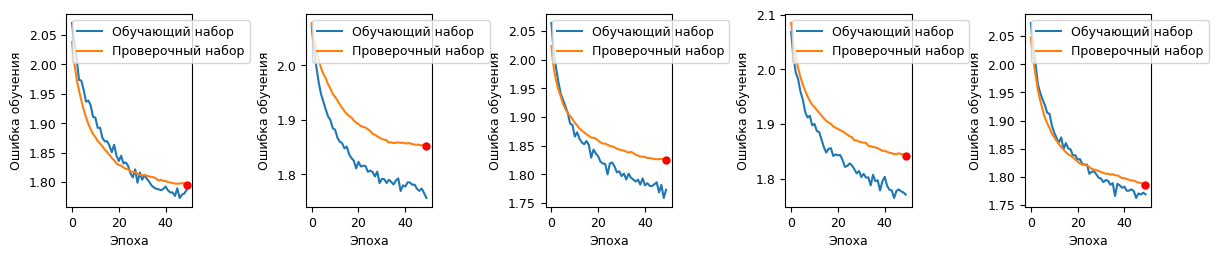

In [40]:
model = SER_one_layer_NN(306,8).to(device)
n_epochs = 50
optimizer = Adam(model.parameters(),lr=1e-4, weight_decay=1e-2) # weight_decay is L2 regularization
loss_fn = nn.CrossEntropyLoss()

SER_data_set = SER_Dataset('')

k_fold_CV(dataset=SER_data_set, model = model, optimizer=optimizer, loss_fn = loss_fn, n_epochs=n_epochs)